# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple. * Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

TO-DO liste

1.INITIALISATION

* "Dynamiser" x_n qui est fixe au cours du temps pour le moment:
    
    -Faire varier Tn_heat sur l'année
    
    -Pareil pour delta_cool (on peut aussi supprimer x_cool ?) 
    
    -k_day_type: doit dépendre du jour de la semaine/vacances,etc... --> créer une nouvelle variable qui récupère les jours de la semaine, weekend, etc... et construire k_day_type (ZAK)
 
 
2.FILTRAGE (paramètres fixes)
Fixer à la main les paramètres sans s'occuper de l'initialisation


3.PREDICTION (paramètres fixes)

4.PMCMC (paramètres refités à chaque nouvelle prédiction)
    




In [3]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

In [4]:
import pymc
from pymc import MCMC

### Parameters

In [125]:
n0=365 #Initialisaion sample
M=10**5 #number of particles
n_pred=48
N_daytype=8
burnin_halfhour=1000  #burnin period in 30min interval
burnin_days=28 #burnin period in # of days

In [6]:
#Define some functions that will be essential for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5
    R=sum((M*w_h).astype(int))
    if R>M:
        return(print("weights are too heavy"))
    z=np.zeros(M)
    z[:R-1]=x_h[:R-1]
    w_=(M*w_h-(M*w_h).astype(int))/(M-R-1)
    z[R:]=sum(w_)
    return(z)

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [8]:
#test the functions on random sample
#resid_resample(npr.normal(size=10),np.repeat(0.1,10))

In [9]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([ 0.42912781, -2.76937628, -0.61400358, -1.84106084,  1.84035394,
       -0.68564063, -0.19559896,  0.35029793,  0.64999646,  0.4498488 ])

In [47]:
"""
#truncated normal
lower = 0
upper = np.inf
mu = 0
sigma = 10^8
N = 1
sigma_s = np.asscalar(stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N))
g_h = np.asscalar(stats.truncnorm.rvs((-np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))
s0 = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))
g_c = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))
#u_h=npr.normal(14,1)
#N_daytype=1
#p=np.ones(N_daytype)
#k_day=np.asscalar(npr.dirichlet(p,1))
#sigma2, sigma2_s0, sigma2_g0, sigma2_s, sigma2_g = invgamma.rvs(a=0.01,scale=0.01,size=5)
delta_c = 5 #to be updated
T_h = 12 #to be updated
"""

'\n#truncated normal\nlower = 0\nupper = np.inf\nmu = 0\nsigma = 10^8\nN = 1\nsigma_s = np.asscalar(stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N))\ng_h = np.asscalar(stats.truncnorm.rvs((-np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))\ns0 = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))\ng_c = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))\n#u_h=npr.normal(14,1)\n#N_daytype=1\n#p=np.ones(N_daytype)\n#k_day=np.asscalar(npr.dirichlet(p,1))\n#sigma2, sigma2_s0, sigma2_g0, sigma2_s, sigma2_g = invgamma.rvs(a=0.01,scale=0.01,size=5)\ndelta_c = 5 #to be updated\nT_h = 12 #to be updated\n'

### Simulate temperatures for T_heat

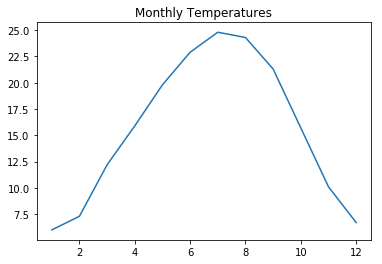

In [10]:
temp_month=np.array([6,7.3,12.2,15.9,19.8,22.9,24.8,24.3,21.3,15.7,10.1,6.7])  #monthly max temp in Paris
month=['jan','fev','mar','av','may','juin','juil','aou','sep','oct','nov','dec']
days_month=np.array([31,29,31,30,31,30,31,31,30,31,30,31])
i=0
temp_={}
for m in month:
    temp_[m]=np.repeat(temp_month[i],days_month[i])
    i=i+1
temp_month_mean=np.ones(0)
for m in month:
    temp_month_mean=np.concatenate((temp_month_mean,temp_[m]),axis=0)

plt.plot(range(1,13),temp_month)
plt.title('Monthly Temperatures')
plt.show()

In [8]:
# T_heat: only temperatures over u_heat
#T_h=np.copy(temp_month_mean)
#T_h[T_h < u_h]=u_h

#delta_cool=np.copy(temp_month)
#delta_cool[delta_cool >= u_h]=u_h

### Load the data

In [126]:
path_AG="/Users/antoinegrelety/Documents/smc_electricity_forecast/data/"
df=pd.read_csv(path_AG+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df.index=range(0,len(df))

In [127]:
df.head()

,Unnamed: 0,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype0,daytype1,daytype2,daytype3,daytype4,daytype6,daytype5,daytype7,daytype8
0,0,2009-06-06T06:00:00+02:00,2009-06-06,06:00,35984,Définitive,False,False,True,False,False,False,False,False,False
1,1,2009-06-06T09:00:00+02:00,2009-06-06,09:00,43188,Définitive,False,False,True,False,False,False,False,False,False
2,2,2009-06-06T11:30:00+02:00,2009-06-06,11:30,46959,Définitive,False,False,True,False,False,False,False,False,False
3,3,2009-06-06T12:30:00+02:00,2009-06-06,12:30,48622,Définitive,False,False,True,False,False,False,False,False,False
4,4,2009-06-06T20:30:00+02:00,2009-06-06,20:30,42578,Définitive,False,False,True,False,False,False,False,False,False


In [128]:
df=df.sort_values(by=['Date'])
df.index=range(0,len(df))
#Valeurs intermédiaires à partir de 2017

In [129]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]

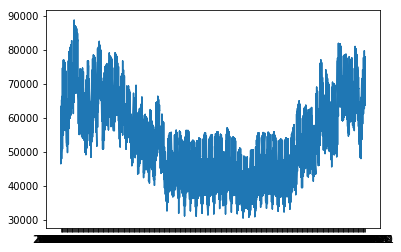

In [130]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

In [131]:
#try a different approach: consider 2pm daily time series
df_day=df[df.Heure=='14:00']
y_n=df_day['Consommation (MW)']
y_n=y_n[:burnin_days]

In [52]:
#y_n=df['Consommation (MW)']
#y_n=y_n[:burning_period]
#y_n=y_n.values

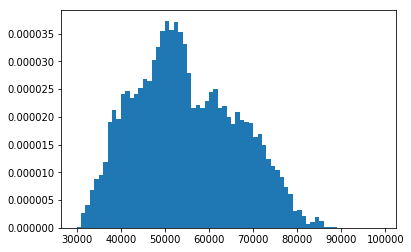

In [27]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

In [255]:
for k in range(0,9):
    df['daytype'+str(k)] = df['daytype'+str(k)].apply(lambda x:k if x==True else 0)


## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

In [156]:
delta_c = 5 #to be updated
sigma2=invgamma.rvs(a=0.01,scale=0.01)

In [157]:
sigma2  #very, very volatile parameter

5.1804643972893395e+63

In [158]:
s0=pymc.TruncatedNormal("s0",mu=0,tau=1/(10^8),a=0,b=np.inf)
gc=pymc.TruncatedNormal("gc",mu=0,tau=1/(10^8),a=0,b=np.inf)
g0=pymc.TruncatedNormal("g0",mu=0,tau=1/(10^8),a=0,b=np.inf)
g0_h=pymc.TruncatedNormal("g0_h",mu=0,tau=1/(10^8),a=-np.inf,b=0)
u_h=pymc.Normal("u_h",mu=14,tau=1)

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


In [159]:
k_day=(npr.dirichlet(size = 1, alpha = [1]*8))[0]*N_daytype  #initialize k_day without pymc
daytype=0  #initialised at 0 (Monday)
day=0 #day of the year (from 0 to 365)
T_h=temp_month_mean #vector of length 365, takes average monthly temperature for each day of the year
#to be refined later (eg access to daily temperatures
#and aggregate temperatures from all weather stations in France Métropolitaine)

In [160]:
@pymc.deterministic(plot=False)
def x_season(s0=s0,k_day=k_day,daytype=daytype):
    out=np.empty(len(y_n))
    out.fill(s0*np.asscalar(k_day[daytype]))
    return(out)

@pymc.deterministic(plot=False)
def x_heat(g0_h=g0_h,T_h=T_h,u_h=u_h,day=day):
    out=np.empty(len(y_n))
    ind=lambda x:1 if u_h>x else 0   #x_heat is unobservable in warm days (temperatures above u_heat)
    vfunc=np.vectorize(ind)          #Therefore we initialize the filter during cooler days, in January
    out.fill(g0_h*(T_h[day]-u_h)*vfunc(T_h[day]))
    return(out)

@pymc.deterministic(plot=False)
def x_cool(g_c=gc,detla_c=delta_c):
    out=np.empty(len(y_n))
    out.fill(g_c*delta_c)
    return(out)

@pymc.deterministic(plot=False)
def x(x_season=x_season, x_heat=x_heat, x_cool=x_cool):
    out=np.empty(len(y_n))
    out=x_season+x_heat+x_cool
    return(out)


In [161]:
y=pymc.Normal("y",mu=x,tau=sigma2,value=y_n,observed=True)

In [162]:
model=pymc.Model([s0,gc,g0,g0_h,u_h,x_season,x_heat,x_cool,x,y])

In [163]:
y.parents

{'mu': <pymc.PyMCObjects.Deterministic 'x' at 0x11dab2710>,
 'tau': 5.1804643972893395e+63}

In [164]:
sampler=MCMC(model)

In [165]:
sampler.sample(iter=1000*(burnin_days-1), burn=burnin_days-1, thin=10) 

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


 [-----------------100%-----------------] 27000 of 27000 complete in 26.9 sec

In [166]:
s_tr = sampler.trace("s0")

In [167]:
sampler.trace("s0")[0:20]  # Just look at the first few values

array([  5.19324751,   6.85491639,   9.06513871,  11.08445891,
        14.76827124,  15.68513674,  16.52148266,  18.68033356,
        20.15295026,  21.35807349,  23.77418189,  26.81981785,
        29.56646369,  32.18561261,  33.45925398,  35.15409746,
        37.88575692,  40.84307048,  42.08522528,  43.63830463])

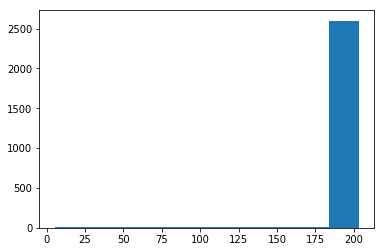

In [168]:
%matplotlib inline
plt.hist(s_tr[:])
plt.show()

Plotting s0
Plotting u_h
Plotting gc
Plotting g0
Plotting g0_h


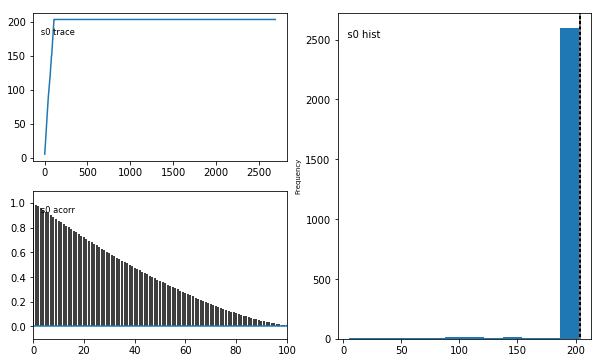

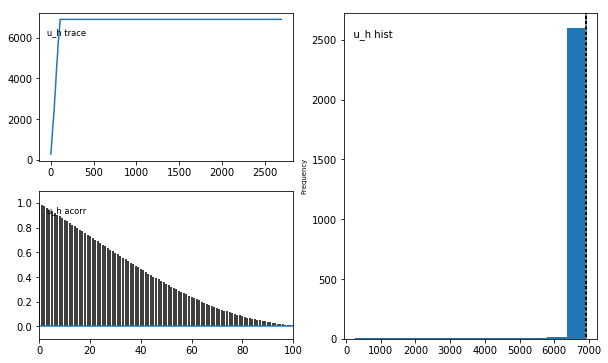

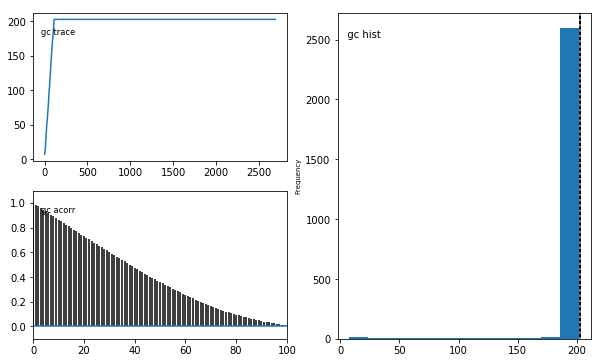

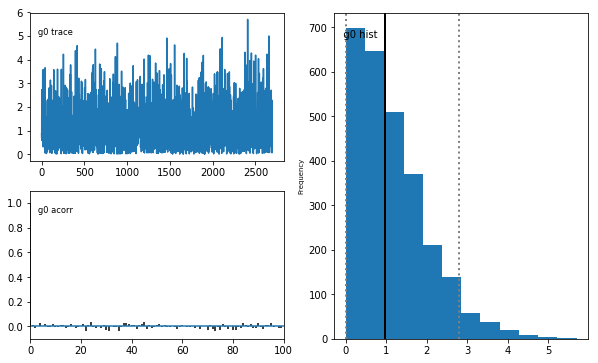

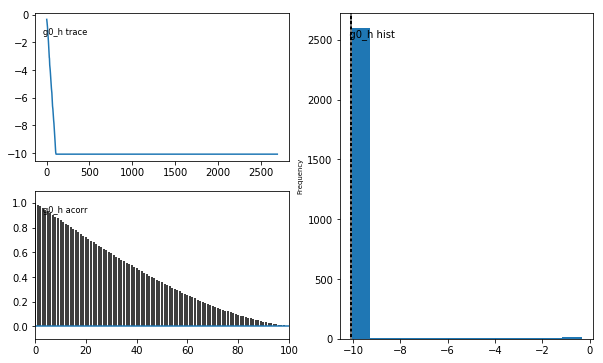

In [169]:
pymc.Matplot.plot(sampler)

In [170]:
#take the value of the last iteration for each parameter. These parameters will be the used to estimate X_0
s0=sampler.trace("s0")[-1]
u_h_0=sampler.trace("u_h")[-1]
gc=sampler.trace("gc")[-1]
g0=sampler.trace("g0")[-1]
g0_h=sampler.trace("g0_h")[-1]

In [171]:
#Generate M times X_0
x_season =np.zeros([n_pred+1,M])
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

#Assume all M particles take the same value at initial state
x_season[0,:]=s0*k_day[daytype]
x_heat[0,:]=g0_h*(T_h[day]-u_h_0)*1

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now


### 2.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [172]:
w0 =np.zeros([1,M])
w0_=x_0+npr.normal(0,sigma2,size=M)
w0_h=w0_/sum(w0_)
ESS_0=1/((sum(w0_h))**2)
print(ESS_0/M)

1e-05


In [173]:
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w0[0,:]=np.ones(M)*(1/M)
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w0[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w0[0,:]=w0_

In [180]:
x[0,:10]

69707.184175716335

In [175]:
w0[0,:10]

array([  1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05])

(array([      0.,       0.,       0.,       0.,       0.,  100000.,
              0.,       0.,       0.,       0.]),
 array([ 69706.68417572,  69706.78417572,  69706.88417572,  69706.98417572,
         69707.08417572,  69707.18417572,  69707.28417572,  69707.38417572,
         69707.48417572,  69707.58417572,  69707.68417572]),
 <a list of 10 Patch objects>)

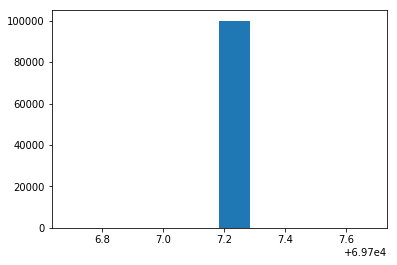

In [176]:
plt.hist(x[0,:])

## Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles